# Medical Summary Reports Clustering

In [6]:
import xml.etree.ElementTree as ET
import re
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [7]:
%cd E:\USF - BAIS\Text Analytics\Project Data\Smoking\smokers_surrogate_train_all_version2

E:\USF - BAIS\Text Analytics\Project Data\Smoking\smokers_surrogate_train_all_version2


## Data parsing - Extraction of data from XML files

In [8]:
myc=0
c = 0
list_of_everything = []
with open(r'E:\USF - BAIS\Text Analytics\Project Data\Smoking\smokers_surrogate_train_all_version2\smokers_surrogate_train_all_version2.xml') as fp:
    tree = ET.parse(fp)
    #Storing all the record IDs in a list
    recordids = []
    for child in tree.getroot():
        id = int(child.attrib['ID'])
        recordids.append(id)
#         
        mydict = {}
        mydict['id'] = child.attrib['ID']
        mydict['smoking_status'] = child[0].attrib['STATUS'].lower()

        content_list = child[1].text.split('\n')
        for index, line in enumerate(content_list):
            if re.match("^[\w*\s*\/]*\:$",line):
                mydict[re.search('[\w*\s*\/]*',line).group(0).strip().lower()]  = ''
        
        #Iterating through TEXT Tag and matching expression precedding colon (:) to define Attribute in a Report e.g. Admission Date 
        i=0
        key=''
        for j in range(len(content_list)):


            # Iterating within TEXT again with another pointer to fetch the actual content within the tag
            if (re.search('[\w*\s*\/]*',content_list[j]).group(0).strip().lower() in mydict):
                i=j
                key = re.search('[\w*\s*\/]*',content_list[i]).group(0).strip().lower()
                
            if(re.search('[\w*\s*\/]*',content_list[j]).group(0).strip().lower() not in mydict and key):
                mydict[key]+=content_list[j]+', '
                c+=1
        list_of_everything.append(mydict)


In [9]:
myc=0
c = 0
#appending data from other data XML files
with open(r'E:\USF - BAIS\Text Analytics\Project Data\Smoking\smokers_surrogate_test_all_version2\smokers_surrogate_test_all_version2.xml') as fp:
    tree = ET.parse(fp)
    #Storing all the record IDs in a list
    recordids = []
    for child in tree.getroot():
        id = int(child.attrib['ID'])
        recordids.append(id)
#         
        mydict = {}
        mydict['id'] = child.attrib['ID']
#         mydict['smoking_status'] = child[0].attrib['STATUS'].lower()

        content_list = child[0].text.split('\n')
        for index, line in enumerate(content_list):
            if re.match("^[\w*\s*\/]*\:$",line):
                mydict[re.search('[\w*\s*\/]*',line).group(0).strip().lower()]  = ''
        
        #Iterating through TEXT Tag and matching expression precedding colon (:) to define Attribute in a Report e.g. Admission Date 
        i=0
        key=''
        for j in range(len(content_list)):
            
            try:

            # Iterating within TEXT again with another pointer to fetch the actual content within the tag
                if (re.search('[\w*\s*\/]*',content_list[j]).group(0).strip().lower() in mydict):
                    i=j
                    key = re.search('[\w*\s*\/]*',content_list[i]).group(0).strip().lower()

                if(re.search('[\w*\s*\/]*',content_list[j]).group(0).strip().lower() not in mydict and key):
#                     print(type(mydict[key]))
                    mydict[key]+=content_list[j]+', '
#                     print(key)
                    c+=1
            except:
                continue
        list_of_everything.append(mydict)


## Extracting only "Diagnosis" fields from data files

In [10]:
list_key_imp = []
id_list = set()
mymap = {}
c=0
for d in list_of_everything:

    mylist=''
    for k,v in d.items():
        if ('diagnosis' in k):
            
            try:
                id_list.add(d['id'])
                mylist+=''.join(v)
                
            except:
#                 print(d['id'])
                pass
    try:
        if mylist:
            mymap[d['id']] = mylist
    except:
        continue
#     print(mylist)
            
    if mylist:
#         c+=1
        list_key_imp.append(' '.join(mylist))
mymap

{'641': 'Carcinoma of the colon ., Urinary tract infection , and cirrhosis of the liver ., ',
 '643': 'Right lung choriocarcinoma ., Pericardial effusion ., ',
 '681': 'PROSTHETIC AORTIC VALVE DYSFUNCTION, ',
 '786': 'RECURRENT DISLOCATION OF LEFT TOTAL HIP PROSTHESIS ., ',
 '872': 'Small cell lung cancer ., Chronic obstructive pulmonary disease , left upper extremity venous thrombosis ., ',
 '535': 'Mediastinal tumor mass ., History of colon cancer , chronic obstructive pulmonary disease , obesity , hypertension , history of myocardial infarction ., ',
 '540': 'Ovarian mass ., Papanicolaou smear positive for somomabodies , incontinence ., ',
 '543': 'Osteochondromatosis , right knee ., ',
 '563': 'Coronary artery disease ., Non-insulin dependent diabetes mellitus , history of gastric ulcer , and history of ETOH abuse ., ',
 '564': 'Non-Q wave myocardial infarction ., Status post anterior myocardial infarction in 05-93 , status post percutaneous transluminal coronary angioplasty of lef

In [ ]:
def clean_text(astr):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    stop_words = nltk.corpus.stopwords.words('english')
    clean_list=[]
    cleantext = re.sub('-',' ',re.sub('[^a-z]+\s', ' ', re.sub('\W\s|\d+', '', astr.replace('\n', ' ').lower())))
    words = [w for w in cleantext.split() if w not in stop_words ]
    words = [lemmatizer.lemmatize(w) for w in words]
    cleantext = ' '.join(words)
    clean_list.append(cleantext)
    
    return clean_list

In [13]:
data = list_key_imp
clean_list = []
clean_dict = {}

from nltk.stem import WordNetLemmatizer
import nltk
from textblob import TextBlob
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
stop_word = stop_words.remove('and') #removing and from stop words list as "and" was being used to separate two different medical terms


#Cleaning the text collected across keys 'History of Patient Illness' and 'Social History'

for key, value in mymap.items():
    cleantext = re.sub('-',' ',re.sub('[^a-z]+\s', ' ', re.sub('\W\s|\d+', '', value.replace('\n', ' ').lower())))
    words = [w for w in cleantext.split() if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    cleantext = ' '.join(words)
    text_new = ''
    text = TextBlob(cleantext)
    cleantext = ''
    for word, pos in text.tags:
        if (pos in ['NN','NNP','NNS','NNPS','VB','VBZ','VBP','VBD','VBN','VBG','JJ','CC']):
            words = lemmatizer.lemmatize(word)
            text_new =  text_new + ' ' + words
    print(text_new)

    clean_dict[key] = str(text_new)


 carcinoma colon .urinary tract infection and cirrhosis liver
 lung choriocarcinoma .pericardial effusion
 prosthetic aortic valve dysfunction
 recurrent dislocation left total hip prosthesis
 small cell lung cancer .chronic obstructive pulmonary disease left upper extremity venous thrombosis
 mediastinal tumor mass .history colon cancer chronic obstructive pulmonary disease obesity hypertension history myocardial infarction
 ovarian mass .papanicolaou smear positive somomabodies incontinence
 osteochondromatosis knee
 coronary artery disease .non insulin dependent diabetes mellitus history gastric ulcer and history etoh abuse
 q wave myocardial infarction .status post anterior myocardial infarction status post percutaneous transluminal coronary angioplasty left anterior descending hypertension diabetes mellitus
 acute myocardial infarction .lower gastrointestinal bleed
 papillary adenocarcinoma lung
 chronic obstructive pulmonary disease pulmonary hypertension .bronchitis
 pelvic mass

In [14]:
clean_dict_df = pd.DataFrame(list(clean_dict.items()), columns=['ID', 'Diagnosis'])
clean_dict_df.to_csv(r'E:\USF - BAIS\Text Analytics\Project Data\clean_med_terms-final.csv')

## Exploratory Data Analysis

In [32]:
clean_list = list(clean_dict.values())

In [36]:
word_list = []

for record in clean_list:
#   print(record)
    record_list = record.split(' ')
    for word in record_list:
        if (word != ''):
            word_list.append(word)
#         print(word)
for word in word_list:
    count = Counter(word_list).most_common()


Text(0.5, 1.0, 'most frequent words from Medical Summary reports')

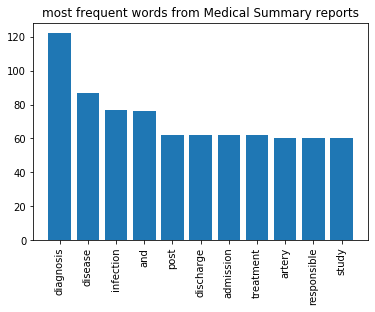

In [38]:
word,freq = zip(*count[0:11])
plt.bar(word,freq)
plt.xticks(rotation=90)
plt.title('most frequent words from Medical Summary reports')

#### TFIDF Clean List with Uni-grams

In [60]:

from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()                      # TF-IDF
vec = TfidfVectorizer(stop_words='english', max_df=0.75,ngram_range=(1,1))
tfidf_clean = vec.fit_transform(clean_list)

#### Elbow curve for determining the Number of clusters

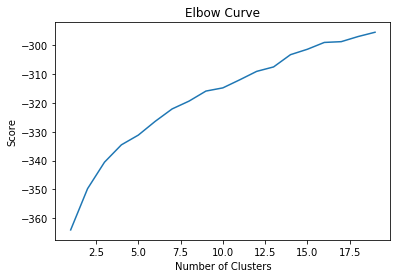

In [43]:
#Clean
N = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in N]
kmeans
score = [kmeans[i].fit(tfidf_clean).score(tfidf_clean) for i in range(len(kmeans))]
score

plt.plot(N, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


There is a small drop at approx. k = 6. Hence, moving ahead with 6 number of clusters for the analysis.

#### Clean-list Clustering with uni-grams

2    201
0     60
5     49
4     32
3     23
1      9
Name: cluster_clean, dtype: int64
Cluster 0:
 diagnosis
 treatment
 condition
 complication
 study
 responsible
 causing
 affecting
 admission
 discharge
 infection
 stay
 chest
 pregnancyprincipal
 htn
Cluster 1:
 delivery
 vaginal
 degree
 normal
 laceration
 second
 lac
 labial
 expired
 fertility
 fetal
 fever
 fhx
 fibrillation
 fibroid
Cluster 2:
 carcinoma
 left
 right
 pain
 metastatic
 acute
 abdominal
 hypertension
 pneumonia
 infection
 wound
 lung
 renal
 infarction
 hemorrhage
Cluster 3:
 cancer
 endometrial
 colon
 vulvar
 rectal
 metastatic
 ovarian
 prostate
 recurrent
 hypopharyngeal
 vaginal
 liver
 lung
 adenocarcinoma
 venous
Cluster 4:
 status
 post
 history
 hypertension
 valve
 syndrome
 grafting
 oophorectomy
 disease
 myocardial
 infarction
 right
 cancer
 replacement
 salpingo
Cluster 5:
 disease
 coronary
 artery
 heart
 failure
 congestive
 chronic
 pulmonary
 infarction
 hypertension
 myocardial
 history

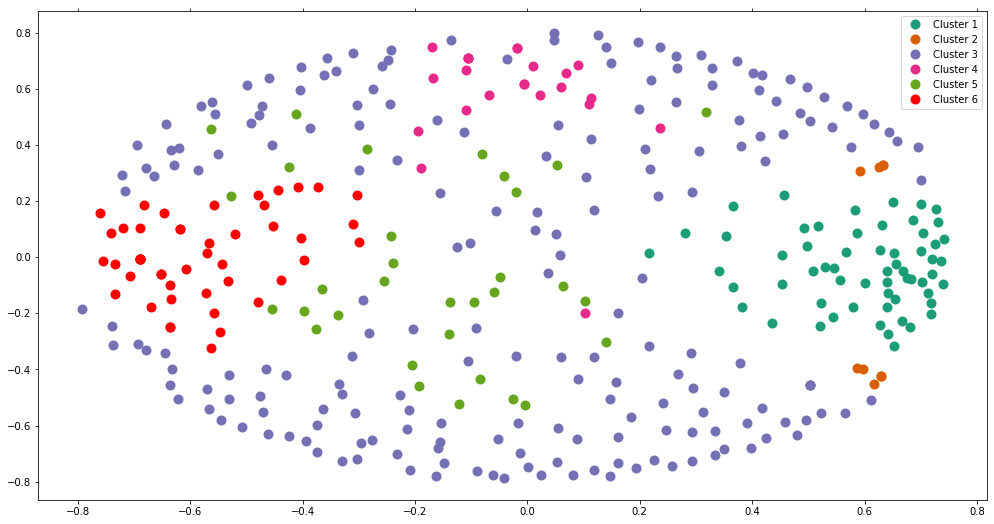

In [61]:

df = pd.DataFrame()
num_clusters = 6

km = KMeans(n_clusters=num_clusters,max_iter = 700)
km.fit(tfidf_clean)
labels = km.labels_
clusters = labels.tolist()
df = pd.DataFrame(list(clean_list))
df['cluster_clean'] = clusters
#print(df.index)
print(df['cluster_clean'].value_counts())

order_centroids_clean = km.cluster_centers_.argsort()[:, ::-1]
terms_clean = vec.get_feature_names()

len(terms_clean), len(order_centroids_clean[0])

for i in range(num_clusters):
    print('Cluster %d:' % i)
    for ind in (order_centroids_clean[i, :15]):
        print(' %s' % terms_clean[ind])
        

# Convert into two components using MDS to plot on a 2D plane

from sklearn.metrics.pairwise import cosine_similarity
distance = 1 - cosine_similarity(tfidf_clean)  
distance

from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pos = mds.fit_transform(distance)
pos
xs, ys = pos[:, 0], pos[:, 1]

# Set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 
                 3: 'Cluster 4', 4: 'Cluster 5', 5: 'Cluster 6'}
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 
                  3: '#e7298a', 4: '#66a61e', 5: '#ff0000'}

# Plot clusters #Uni-Gram
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))

for name, group in groups:
    ax.plot(group.x, group.y, marker='.', linestyle='', ms=20, 
        label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    
ax.legend(numpoints=1) 
plt.show()

#### TFIDF Clean List - Bi-gram

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()                      # TF-IDF
vec = TfidfVectorizer(stop_words='english', max_df=0.75,ngram_range=(2,2))
tfidf_clean = vec.fit_transform(clean_list)

#### Clean list clustering with Bi-Grams


0    240
3     60
1     43
2     25
4      4
5      2
Name: cluster_clean, dtype: int64
Cluster 0:
 vaginal delivery
 endometrial cancer
 wound infection
 myocardial infarction
 colon cancer
 normal vaginal
 degree laceration
 tract infection
 urinary tract
 sternal wound
 cell carcinoma
 chest pain
 vulvar cancer
 prostate cancer
 second degree
Cluster 1:
 status post
 chronic obstructive
 obstructive pulmonary
 pulmonary disease
 myocardial infarction
 atrial fibrillation
 right hip
 hip fracture
 heart failure
 infarction status
 coronary artery
 failure chronic
 radiation therapy
 disease pulmonary
 salpingo oophorectomy
Cluster 2:
 coronary artery
 artery disease
 congestive heart
 heart failure
 failure coronary
 myocardial infarction
 disease congestive
 ventricular fibrillation
 bypass graft
 tachycardia coronary
 disease hypertension
 artery bypass
 infarction coronary
 edema congestive
 mass inferior
Cluster 3:
 infection complication
 diagnosis responsible
 complication affe

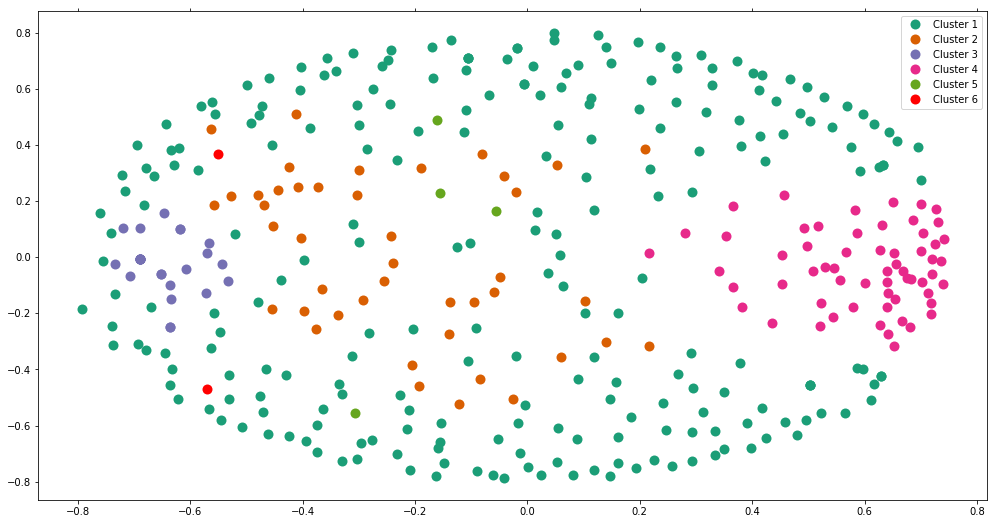

In [64]:
df = pd.DataFrame()
num_clusters = 6

km = KMeans(n_clusters=num_clusters,max_iter = 700)
km.fit(tfidf_clean)
labels = km.labels_
clusters = labels.tolist()
df = pd.DataFrame(list(clean_list))
df['cluster_clean'] = clusters
#print(df.index)
print(df['cluster_clean'].value_counts())

order_centroids_clean = km.cluster_centers_.argsort()[:, ::-1]
terms_clean = vec.get_feature_names()

len(terms_clean), len(order_centroids_clean[0])

for i in range(num_clusters):
    print('Cluster %d:' % i)
    for ind in (order_centroids_clean[i, :15]):
        print(' %s' % terms_clean[ind])
        
from sklearn.metrics.pairwise import cosine_similarity
distance = 1 - cosine_similarity(tfidf_clean)  
distance

from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pos = mds.fit_transform(distance)
pos
xs, ys = pos[:, 0], pos[:, 1]

# Set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 
                 3: 'Cluster 4', 4: 'Cluster 5', 5: 'Cluster 6'}
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 
                  3: '#e7298a', 4: '#66a61e', 5: '#ff0000'}

# Plot clusters #Uni-Gram
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))

for name, group in groups:
    ax.plot(group.x, group.y, marker='.', linestyle='', ms=20, 
        label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    
ax.legend(numpoints=1) 
plt.show()

#### TFIDF Clean List - Tri-gram

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()                      # TF-IDF
vec = TfidfVectorizer(stop_words='english', max_df=0.75,ngram_range=(3,3))
tfidf_clean = vec.fit_transform(clean_list)

####  Clean list clustering with Tri-Grams


2    248
3     58
0     34
5     25
4      5
1      4
Name: cluster_clean, dtype: int64
Cluster 0:
 congestive heart failure
 prosthetic aortic valve
 aortic valve dysfunction
 pneumonia dementia congestive
 aspiration pneumonia dementia
 dementia congestive heart
 abdominal pain partial
 pain partial small
 infarction hypertension gout
 acute inferior myocardial
 myocardial infarction hypertension
 partial small bowel
 small bowel obstruction
 inferior myocardial infarction
 adenocarcinoma unknown primary
Cluster 1:
 atypical chest pain
 peptic ulcer disease
 cholangiocarcinoma biliary obstruction
 biliary obstruction hypertension
 obstruction hypertension peptic
 hypertension peptic ulcer
 cirrhosis tuberculosis childhood
 varix hepatic hydrothorax
 hepatic encephalopathy grade
 right peptic ulcer
 childhood hepatic encephalopathy
 tuberculosis childhood hepatic
 related cirrhosis tuberculosis
 hepatic hydrothorax right
 hydrothorax right peptic
Cluster 2:
 normal vaginal delivery
 s

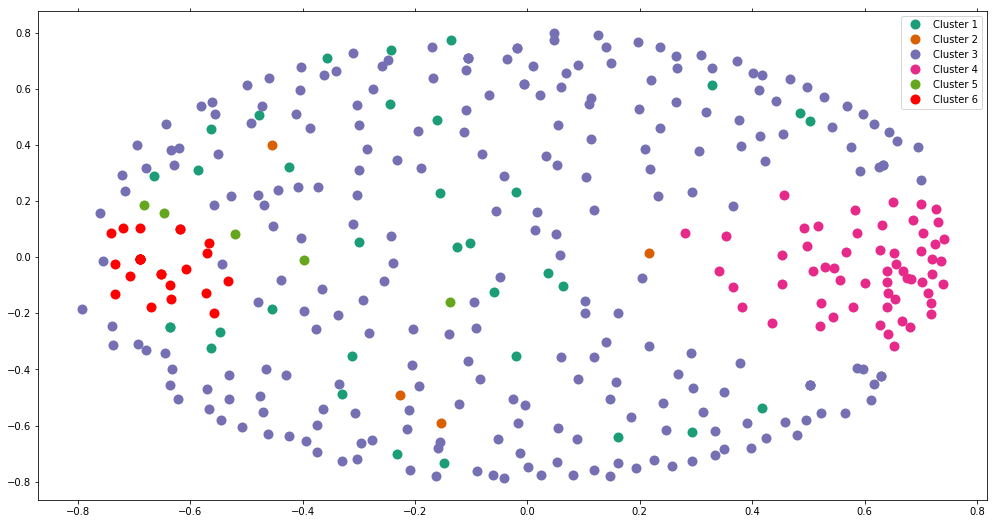

In [69]:
df = pd.DataFrame()
num_clusters = 6

km = KMeans(n_clusters=num_clusters,max_iter = 700)
km.fit(tfidf_clean)
labels = km.labels_
clusters = labels.tolist()
df = pd.DataFrame(list(clean_list))
df['cluster_clean'] = clusters
#print(df.index)
print(df['cluster_clean'].value_counts())

order_centroids_clean = km.cluster_centers_.argsort()[:, ::-1]
terms_clean = vec.get_feature_names()

len(terms_clean), len(order_centroids_clean[0])

for i in range(num_clusters):
    print('Cluster %d:' % i)
    for ind in (order_centroids_clean[i, :15]):
        print(' %s' % terms_clean[ind])
        
from sklearn.metrics.pairwise import cosine_similarity
distance = 1 - cosine_similarity(tfidf_clean)  
distance

from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pos = mds.fit_transform(distance)
pos
xs, ys = pos[:, 0], pos[:, 1]

# Set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 
                 3: 'Cluster 4', 4: 'Cluster 5', 5: 'Cluster 6'}
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 
                  3: '#e7298a', 4: '#66a61e', 5: '#ff0000'}

# Plot clusters #Uni-Gram
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))

for name, group in groups:
    ax.plot(group.x, group.y, marker='.', linestyle='', ms=20, 
        label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    
ax.legend(numpoints=1) 
plt.show()

## Text Analysis - Phase 2 (Med_Features List and Set followed by One Hot Encoding)

#### Cleaning and Extraction of medical tokens was done manually reading summary reports

In [71]:
#load data and create a list of medical condition for every patient.
medterms = pd.read_excel(r"E:\USF - BAIS\Text Analytics\clean_med_terms_Rushi3.xlsx")
c = 0
myset = set()
medterms_rev = medterms.values.tolist()
medterms_final = []
for row in medterms_rev:
    temp_list = []
    for item in row:
        if(isinstance(item,str)):
            temp_list.append(item)
            myset.add(item)
    medterms_final.append(temp_list)

len(medterms_final)

374

In [73]:
medterms.set_index('ID')
medterms.head()

,ID,medterm1,medterm2,medterm3,medterm4,medterm5,medterm6,medterm7,medterm8,medterm9,medterm10,medterm11,medterm12,medterm13,medterm14,medterm15,medterm16,medterm17
0,641,colon carcinoma,urinary tract infection,cirrhosis liver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,643,lung choriocarcinoma,pericardial effusion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,681,prosthetic aortic valve dysfunction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,786,hip prosthesis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,872,lung carcinoma,chronic obstructive pulmonary disease,venous thrombosis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
#finding the frequency of every medical condition in the data

condition_set = set()
condition_list = []
doc_freq = {}
index_list = []
for i, row in medterms.iterrows():
    index_list.append(row[0])
    for j in row :
        if (isinstance(j,str)) and j != ' ':
            condition = str.lower(j).strip()
            condition_set.add(condition)
            condition_list.append(condition)
            doc_freq[condition] = doc_freq.get(condition,0)+1
doc_freq

{'colon carcinoma': 9,
 'urinary tract infection': 9,
 'cirrhosis liver': 1,
 'lung choriocarcinoma': 1,
 'pericardial effusion': 2,
 'prosthetic aortic valve dysfunction': 1,
 'hip prosthesis': 1,
 'lung carcinoma': 4,
 'chronic obstructive pulmonary disease': 13,
 'venous thrombosis': 5,
 'mediastinal tumor mass': 1,
 'obesity': 5,
 'hypertension': 54,
 'myocardial infarction': 33,
 'ovarian mass': 1,
 'papanicolaou smear positive': 1,
 'somomabodies incontinence': 1,
 'osteochondromatosis knee': 1,
 'coronary artery disease': 41,
 'diabetes mellitus': 24,
 'gastric ulcer': 2,
 'etoh abuse': 2,
 'gastrointestinal bleeding': 7,
 'papillary adenocarcinoma lung': 1,
 'bronchitis': 1,
 'pelvic mass': 4,
 'adenocarcinoma': 2,
 'intrauterine pregnancy week': 1,
 'valvular heart disease': 1,
 'cryptogenic cirrhosis': 1,
 'variceal bleeding': 1,
 'hypoglycemic seizure': 1,
 'multiple sclerosis': 1,
 'anemia': 8,
 'knee osteoarthritis': 1,
 'prostate carcinoma': 6,
 'alzheimer disease': 3,
 '

In [75]:
#creating a one hot vector for all medical condition with respect to the record ids
onehot_df = pd.DataFrame(columns = condition_set,index = index_list)

In [76]:
onehot_df = onehot_df.fillna(0)
onehot_df

,thymoma,adenocarcinoma,liver laceration,appendicitis,staphylococcus aureus,scrotal hernia,shortness breath,healing ulcer,cerebral artery embolic stroke,bacteremia,...,leukemia,breast mastectomy,degenerative joint disease,erosive esophagitis,etoh abuse,squamous cell carcinoma,ventricular dysfunction,tricuspid insufficiency,cesarean,somomabodies incontinence
641,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
786,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
import math
#creating a Frequency matrix for the records
for i, row in medterms.iterrows():
    for j in range(1,len(row)):
        if row[j] in onehot_df.columns:
            onehot_df.at[row[0],row[j]] = math.log(1/doc_freq[row[j]])
    

In [79]:
onehot_df.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Cluster 0:
 congestive heart failure
 prostate carcinoma
 hypertension
 alcohol withdrawal seizure
 coronary artery disease
 hypertension
 papillary serous
 colon carcinoma
 thyroid papillary carcinoma
 myocardial infarction
 sepsis
 atrial fibrillation
 atrial fibrillation
 coronary artery disease
 congestive heart failure
Cluster 1:
 coronary artery disease
 venous thrombosis
 diabetes mellitus
 thyroid papillary carcinoma
 smoking
 urinary tract infection
 appendectomy hiatus hernia
 migraine
 hypertension
 rectal carcinoma
 myelogenous leukemia
 rectal carcinoma
 anemia
 thrombocytopenia
 chronic obstructive pulmonary disease
Cluster 2:
 hypertension
 prostate carcinoma
 syncope
 conus medullaris spinal cord
 diverticulosis
 pneumonia
 hypertension
 heart failure
 congestive heart failure
 hypertension
 hypertension
 ovarian carcinoma
 congestive heart failure
 coronary artery disease
 symptomatic anemia
Cluster 3:
 prostate carcinoma
 coronary atherosclerosis
 syncope
 pneumonia
 

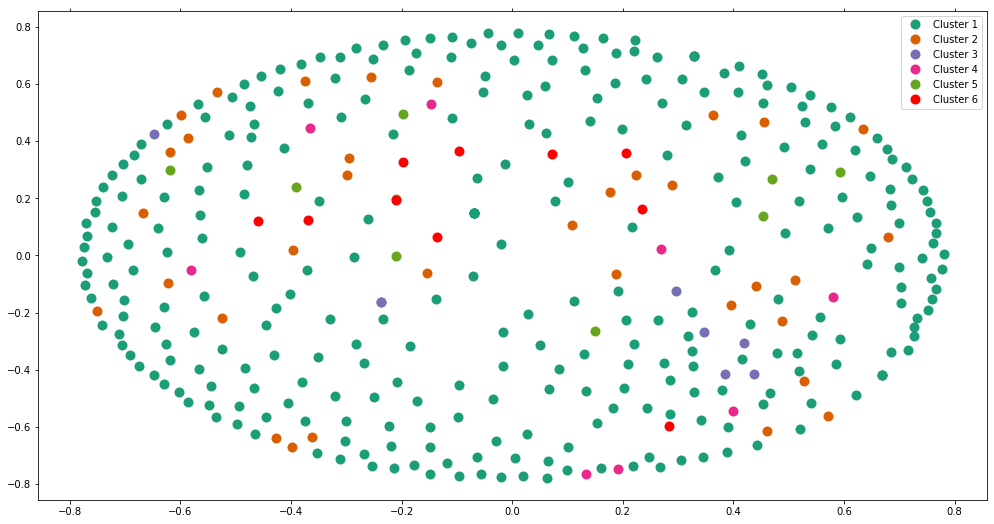

In [93]:
#clustering a TFIDF with bi-grams
# from sklearn.feature_extraction.text import TfidfVectorizer
# vec = TfidfVectorizer()                      # TF-IDF
# vec = TfidfVectorizer(stop_words='english', max_df=0.75,ngram_range=(1,1))
# #new_tfidf_clean = vec.fit_transform(condition_list)

new_df = pd.DataFrame()
num_clusters = 6

km = KMeans(n_clusters=num_clusters,max_iter = 700)
km.fit(onehot_df.values)
labels = km.labels_
clusters = labels.tolist()
new_df = pd.DataFrame(index = index_list)
new_df['cluster_clean'] = clusters

new_order_centroids_clean = km.cluster_centers_.argsort()[:, ::-1]
new_terms_clean = condition_list


for i in range(num_clusters):
    print('Cluster %d:' % i)
    for ind in (new_order_centroids_clean[i, :15]):
        print(' %s' % new_terms_clean[ind])
        
from sklearn.metrics.pairwise import cosine_similarity
distance = 1 - cosine_similarity(tfidf_clean)  
distance

from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pos = mds.fit_transform(distance)
pos
xs, ys = pos[:, 0], pos[:, 1]

# Set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 
                 3: 'Cluster 4', 4: 'Cluster 5', 5: 'Cluster 6'}
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 
                  3: '#e7298a', 4: '#66a61e', 5: '#ff0000'}

# Plot clusters #Uni-Gram
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))

for name, group in groups:
    ax.plot(group.x, group.y, marker='.', linestyle='', ms=20, 
        label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    
ax.legend(numpoints=1) 
plt.show()

# Semantic analysis and clustering

In [97]:
#creating a Word2Vec model and cluster the medical condition 
#this is done to sematically findout interdependent medical conditions
from gensim.models.word2vec import Word2Vec

model = Word2Vec(medterms_final,min_count=1)   

X = model.wv[model.wv.vocab]
#Clean (Includes all the cleaned words)
new_df = pd.DataFrame(index = range(663))
num_clusters = 6
new_df['word'] = myset
km = KMeans(n_clusters=num_clusters,max_iter = 700)
km.fit(X)
labels = km.labels_
clusters = labels.tolist()
print(len(clusters))
new_df['cluster_clean'] = clusters
new_df.sort_values(by = ['cluster_clean'])


663


,word,cluster_clean
662,somomabodies incontinence,0
118,infection,0
314,coronary artery stenosis,0
325,benign prostatic hypertrophy,0
108,presumed pml,0
...,...,...
450,brachial artery,5
452,coronary artery disease,5
453,migraine,5
458,Glaucoma,5


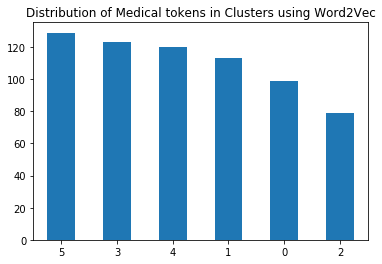

In [101]:
new_df['cluster_clean'].value_counts().plot(kind = 'bar',rot = 0, title = 'Distribution of Medical tokens in Clusters using Word2Vec')

In [95]:
#creting a document vector using Doc2vec and clustering documents
#this is done to find out patients with similar medical condition, taking the semantic into consideration

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(medterms_final)]
documents

model = Doc2Vec(documents,min_count=1)
X = list(model.docvecs.doctag_syn0)
new_df = pd.DataFrame(index = range(374))
num_clusters = 6
new_df['data'] = medterms_final
km = KMeans(n_clusters=num_clusters,max_iter = 700)
km.fit(X)
labels = km.labels_
clusters = labels.tolist()

new_df['cluster_clean'] = clusters

new_order_centroids_clean = km.cluster_centers_.argsort()[:, ::-1]
new_terms_clean = myset
new_terms_clean

new_df.sort_values(by = ['cluster_clean'])

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  # Remove the CWD from sys.path while we load stuff.


,data,cluster_clean
73,"[ anemia, thrombocytopenia, chronic obstructiv...",0
301,"[ mitral stenosis, tricuspid regurgitation, ...",0
111,"[cervical carcinoma, pericardial effusion, pul...",0
145,"[ hepatocellular carcinoma, hepatitis c]",0
348,"[infection, nephropathy, pulmonary disease, ...",0
...,...,...
261,[ vaginal delivery],5
343,"[hepatic flexure, aortic stenosis, obstructi...",5
46,[ leukemia],5
141,"[ myocardial infarction , hypertension , gout]",5


In [106]:
#elbow curve
#finding the distortion in the clusters when the value of K is increased

from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,100) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / len(X) )
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / len(X)
    mapping2[k] = kmeanModel.inertia_ 
    

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.02880268349643957
2 : 0.028586575739207507
3 : 0.028415984315265777
4 : 0.028283690123905122
5 : 0.028173114511688736
6 : 0.02806061186854981
7 : 0.027983064870501523
8 : 0.027867159083970073
9 : 0.02781998951798911
10 : 0.027730591965104474
11 : 0.027650954723148963
12 : 0.02755932555752802
13 : 0.02753652995831055
14 : 0.027396138160567515
15 : 0.027371854573197303
16 : 0.027328175297160476
17 : 0.027246943107477044
18 : 0.027173111129206028
19 : 0.027143394946889342
20 : 0.02710490830159752
21 : 0.027014608654408873
22 : 0.026972499639657945
23 : 0.026893561941409024
24 : 0.026844888744462034
25 : 0.02676389957559375
26 : 0.026726595759846233
27 : 0.0266943653300135
28 : 0.026612886909695172
29 : 0.026538037990381395
30 : 0.026486717765865038
31 : 0.026471424235206657
32 : 0.026319934269173634
33 : 0.026327654258141656
34 : 0.026245119731009067
35 : 0.026245230461616555
36 : 0.02616896332583776
37 : 0.0259883912077245
38 : 0.025999288471758503
39 : 0.025945552484717905
40 : 0.

The distortion is changing after K=6. Therefore, keeping the number of clusters in document clustering to be 6.

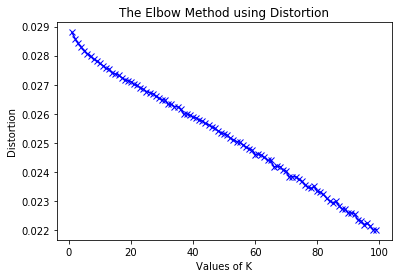

In [107]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [98]:
new_df.to_csv(r'E:\USF - BAIS\Text Analytics\word2vec_medterms.csv')